# Compute the sequence of requests 
## Using the discrete CDF

- Fitting data for execution logs or for synthetic logs
- Generating the sequence of requests
- Computing the cost of a sequence

Input data is represented by:
 * Log data for neuroscience applications (log_example.in)
     * Array of past execution times
 * Synthetic data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random

import WorkloadCDF
import OptimalSequence

In [2]:
plot = False

# Log data

This example computes the sequence of requests
- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit

In [3]:
dataset = "./log_example.in"
data = np.loadtxt(dataset, delimiter=' ')
data.sort()
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 300


# Compute the discrete CDF

Plot it and show best fit by connecting adiacent points with a line

In [4]:
# Optimal CDF by using the discrete full data

wf = WorkloadCDF.WorkloadCDF(data)
optimal_data, optimal_cdf = wf.compute_discrete_cdf()

handler = OptimalSequence.TODiscretSequence(max(data), optimal_data, optimal_cdf)
optimal_sequence = handler.compute_request_sequence()
print("Optimal sequence", optimal_sequence)
cost_handler = WorkloadCDF.LogDataCost(optimal_sequence)
optimal_cost = cost_handler.compute_cost(data)
print("Optimal cost", optimal_cost)

Optimal sequence [(80802.0,), (99019.0,)]
Optimal cost 87073.20333333334


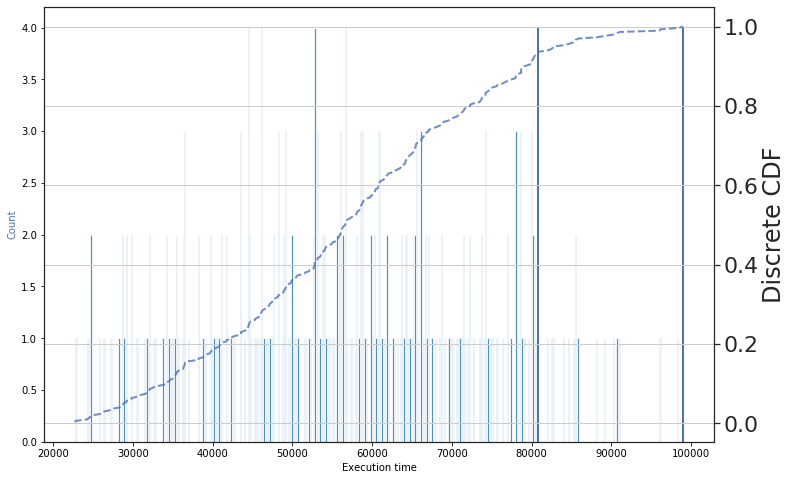

In [5]:
# plot the data and the discrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot discrete fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8)
#ax2.scatter(optimal_data, optimal_cdf, marker="s", color="r", lw=2, alpha=1)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/optimal_sequence.png")
plt.show()

# Interpolate the CDF with a distribution fit

- get best disribution base on the fit

In [6]:
# compute the interpolation of the CDF (for full data)
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)

(<scipy.stats._continuous_distns.dgamma_gen object at 0x7f33e68a6b70>, (1.4333535257553347, 57572.58690394461, 9561.698007657797), 99.65567522936747)


In [7]:
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit)

handler = OptimalSequence.TODiscretSequence(max(data), all_data_discrete, all_data_cdf)
distr_sequence = handler.compute_request_sequence()
print("Distribution sequence", distr_sequence)

Distribution sequence [(77959.0,), (99019.0,)]


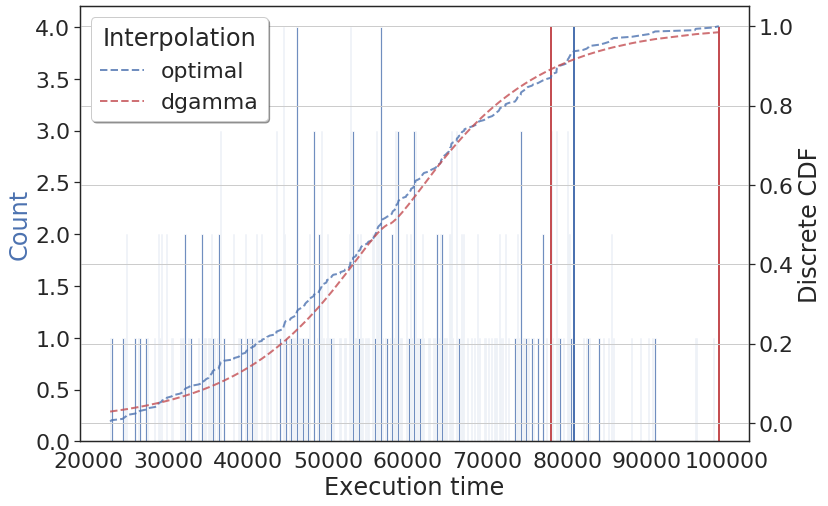

In [8]:
# plot the data and the interpolation CDF

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/distr_sequence.png")
plt.show()

# Use only the first x entries in data for interpolation

In [9]:
# define x
training_size = 10

In [10]:
training_data = random.sample(list(data), training_size)
wf = WorkloadCDF.WorkloadCDF(training_data)
discret_data, cdf = wf.compute_discrete_cdf()

handler = OptimalSequence.TODiscretSequence(max(data), discret_data, cdf)
discrete_sequence = handler.compute_request_sequence()
print("Discrete sequence", discrete_sequence)
cost_handler = WorkloadCDF.LogDataCost(discrete_sequence)
print("Discrete cost", cost_handler.compute_cost(data))

Discrete sequence [(65445.0,), (77993.0,), (99019.0,)]
Discrete cost 101385.30666666667


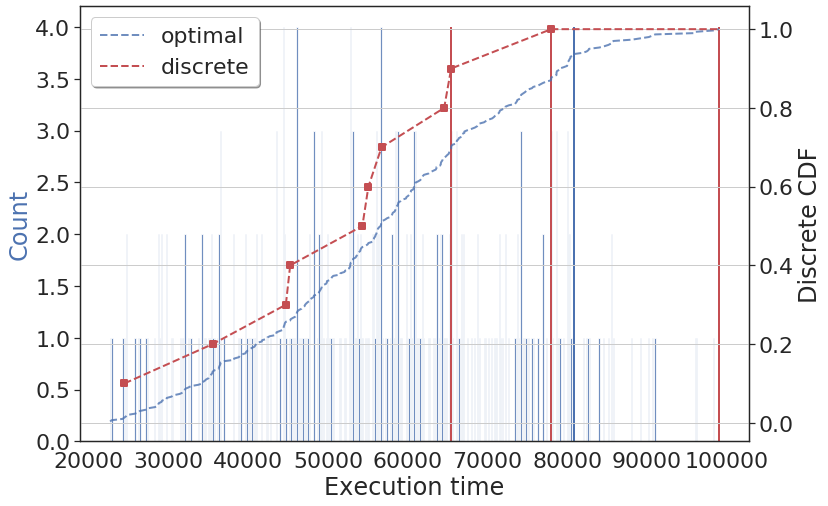

In [11]:
# plot the fit of the discrete fit (using the first x entries)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')


# plot the discrete sequence
ax.vlines(discrete_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# plot sample data
ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1, label="discrete")
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_discrete_seq.png" %(training_size))
plt.show()

# Distribution interpolation

In [12]:
# compute the interpolation of the CDF points
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit)

handler = OptimalSequence.TODiscretSequence(max(data), all_data_discrete, all_data_cdf)
distr_sequence = handler.compute_request_sequence()
print("Distribution sequence", distr_sequence)
cost_handler = WorkloadCDF.LogDataCost(distr_sequence)
print("Distribution cost", cost_handler.compute_cost(data))

(<scipy.stats._continuous_distns.laplace_gen object at 0x7f33e687e470>, (56622.86269563611, 13679.256421157977), 3.849770852564998)
Distribution sequence [(74470.0,), (99019.0,)]
Distribution cost 90643.10333333333


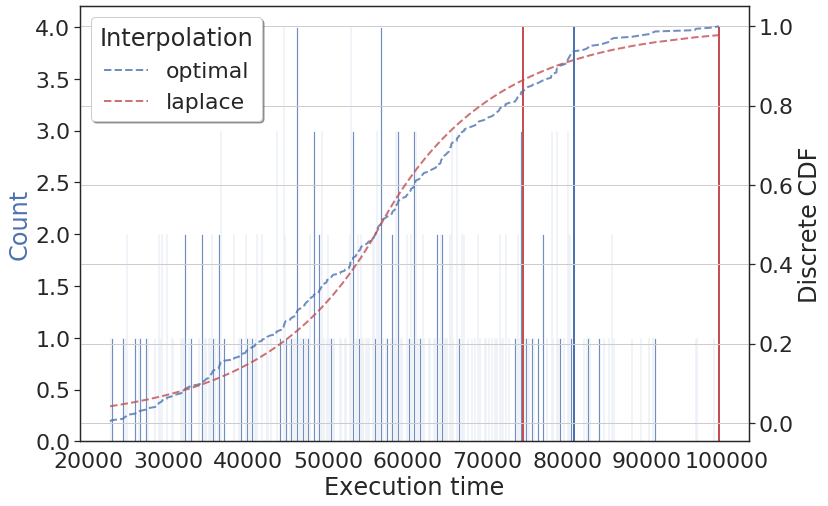

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_distr_seq.png" %(training_size))
plt.show()

# Synthetic workloads

Generate the data using the normal distribution - *Same workflow as for the log dataset*

## 1. Truncnorm

Parameters: $\mu$ = 8
$\sigma$ = 2

Truncated between [0, 20]

In [14]:
bins = 100
distribution = st.truncnorm
lower_limit = 0
upper_limit = 20
mu = 8
sigma = 2
upper_bound = (upper_limit - mu) / sigma
lower_bound = (lower_limit - mu) / sigma

In [15]:
data = distribution.rvs(lower_bound, upper_bound,
                        loc=mu, scale=sigma, size=100)
data.sort()

### Compute and plot the optimal sequence

In [16]:
training_data = random.sample(list(data), training_size)
wf = WorkloadCDF.WorkloadCDF(data)
optimal_data, optimal_cdf = wf.compute_discrete_cdf()

handler = OptimalSequence.TODiscretSequence(max(data), optimal_data, optimal_cdf)
optimal_sequence = handler.compute_request_sequence()
print("Optimal sequence", optimal_sequence)
cost_handler = WorkloadCDF.LogDataCost(optimal_sequence)
optimal_cost = cost_handler.compute_cost(data)
print("Optimal cost", optimal_cost)

# discrete data
wf = WorkloadCDF.WorkloadCDF(training_data)
discret_data, cdf = wf.compute_discrete_cdf()

handler = OptimalSequence.TODiscretSequence(max(data), discret_data, cdf)
discrete_sequence = handler.compute_request_sequence()
print("Discrete sequence", discrete_sequence)
cost_handler = WorkloadCDF.LogDataCost(discrete_sequence)
print("Discrete cost", cost_handler.compute_cost(data))

Optimal sequence [(10.927164125501264,), (13.341115221980207,)]
Optimal cost 11.327397582160659
Discrete sequence [(10.526638703233587,), (13.341115221980207,)]
Discrete cost 11.460516768772225


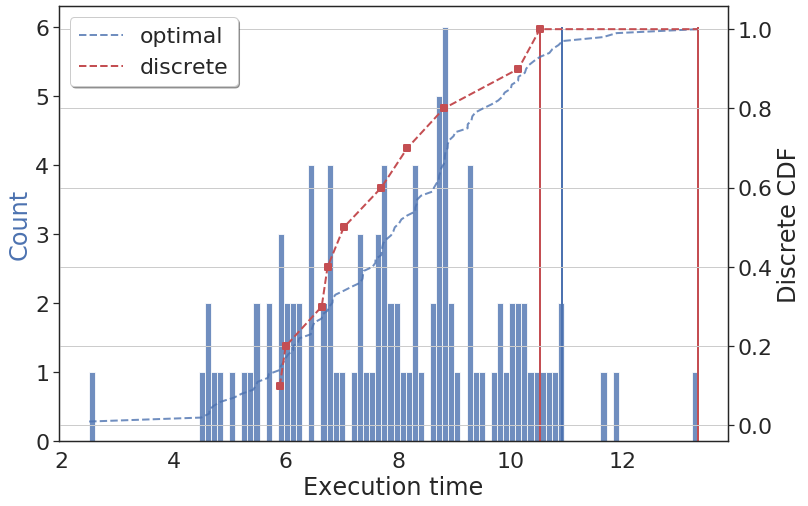

In [17]:
# plot the data and the discrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=100)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')


# plot the discrete sequence
ax.vlines(discrete_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# plot sample data
ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1, label="discrete")
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_discrete_seq.png" %(training_size))
plt.show()

# Use only the first x entris in data for interpolation

In [18]:
# define x
training_size = 10

In [19]:
# compute the interpolation of the CDF points
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit)

handler = OptimalSequence.TODiscretSequence(max(data), all_data_discrete, all_data_cdf)
distr_sequence = handler.compute_request_sequence()
print("Distribution sequence", distr_sequence)
cost_handler = WorkloadCDF.LogDataCost(distr_sequence)
print("Distribution cost", cost_handler.compute_cost(data))

(<scipy.stats._continuous_distns.loggamma_gen object at 0x7f33e687ecc0>, (571.5770674634823, -280.01005444290524, 45.365421702780466), 2.406145333652146)
Distribution sequence [(10.695431817231045,), (13.341115221980207,)]
Distribution cost 11.495898730549845


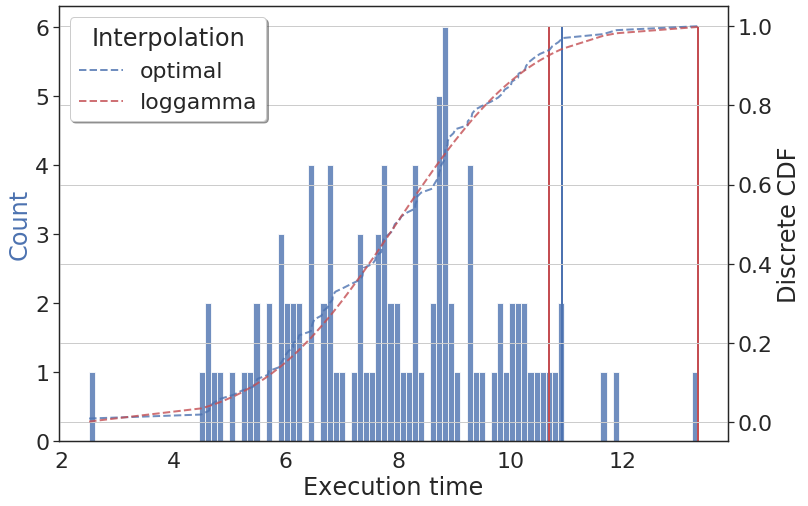

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=100)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/syn%d_distr_seq.png" %(training_size))
plt.show()